# FM_Copula1：Copula を Flow Matching で学習するデモ（S 字依存）

## 概要
- 目的：コピュラの“骨格”からの残差依存を，条件付き流れ（Flow Matching）で吸収できることを可視化します．
- 内容：S 字状の依存構造データを生成し，FM によりサンプルと密度形状の再現（ヒートマップ等）を確認します．
- 実行：上から順に実行（Run All）してください（学習ループあり）．
- 依存：torch, numpy, scipy, matplotlib（GPU は任意）．
- 出力：学習曲線と生成サンプルの可視化（図）．

## 実行メモ
- 乱数性があります（seed を固定したい場合は冒頭セルで設定してください）．
- 実行環境：Python 3 系（推奨：3.10+）．GPU は任意です．


Step 0, Loss: 2.2769
Step 500, Loss: 1.7980
Step 1000, Loss: 1.6960
Step 1500, Loss: 1.5796


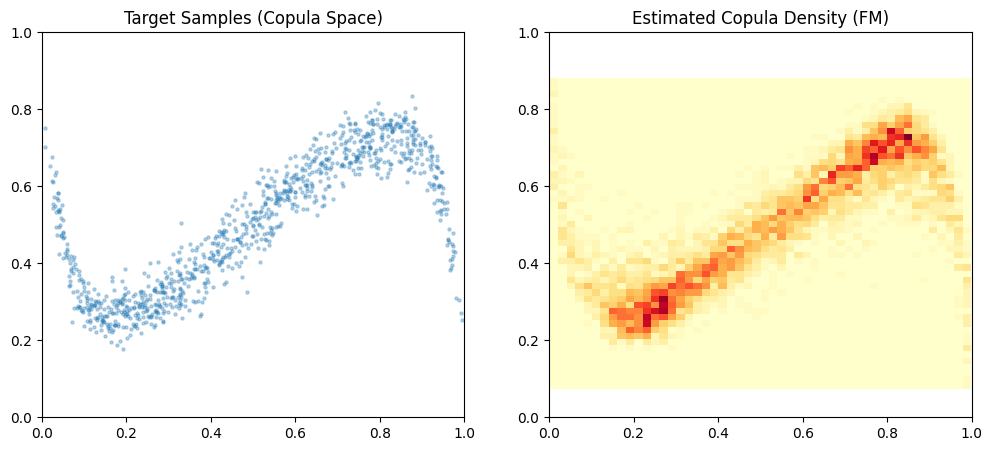

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 1. データ生成: S字型の依存を持つコピュラサンプル
def generate_s_shape_copula(n_samples=5000):
    # ロジット空間でのS字分布
    z1 = torch.randn(n_samples, 1) * 1.5
    z2 = torch.sin(z1) + torch.randn(n_samples, 1) * 0.2
    z = torch.cat([z1, z2], dim=1)

    # [0, 1]空間へ写像 (Copulaサンプル)
    u = torch.sigmoid(z)
    return z, u

# 2. フローマッチング用ネットワーク (ベクトル場 v_t(z) の近似)
class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128):
        super().__init__()
        # 時間 t と座標 z を入力とするため input_dim + 1
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, t, z):
        # t: [batch, 1], z: [batch, 2]
        input_concat = torch.cat([t, z], dim=-1)
        return self.net(input_concat)

# 3. 学習設定
device = "cuda" if torch.cuda.is_available() else "cpu"
z_data, u_data = generate_s_shape_copula(10000)
z_data = z_data.to(device)

model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 学習ループ (Conditional Flow Matching)
for step in range(2000):
    optimizer.zero_grad()

    # サンプリング
    z1 = z_data[torch.randint(0, len(z_data), (512,))]
    z0 = torch.randn_like(z1) # 基準分布 (標準正規)
    t = torch.rand(512, 1).to(device)

    # 線形補間パス [cite: 295]
    zt = (1 - t) * z0 + t * z1
    ut = z1 - z0 # ターゲット速度 (x1 - x0) [cite: 309, 313]

    # 損失計算 (L2回帰) [cite: 311, 493]
    vt = model(t, zt)
    loss = torch.mean((vt - ut)**2)

    loss.backward()
    optimizer.step()

    if step % 500 == 0:
        print(f"Step {step}, Loss: {loss.item():.4f}")

# 4. コピュラ密度の可視化
def plot_results(model, z_data):
    model.eval()
    grid_res = 100
    # [0, 1] 空間の格子点
    u_range = np.linspace(0.01, 0.99, grid_res)
    U1, U2 = np.meshgrid(u_range, u_range)
    u_grid = torch.tensor(np.stack([U1.ravel(), U2.ravel()], axis=1), dtype=torch.float32).to(device)

    # ロジット変換 [cite: 644]
    z_grid = torch.log(u_grid / (1 - u_grid))

    # 簡易的な密度推定 (t=1でのサンプルのヒストグラムによる可視化)
    with torch.no_grad():
        z0 = torch.randn(5000, 2).to(device)
        zt = z0
        dt = 0.1
        for i in range(10): # ODEソルバー (前進オイラー法) [cite: 342, 383]
            t_curr = torch.ones(5000, 1).to(device) * (i * dt)
            zt = zt + dt * model(t_curr, zt)

        u_gen = torch.sigmoid(zt).cpu().numpy()

    # 描画
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))

    # (1) 学習データの散布図 (Copula空間)
    ax[0].scatter(u_data[:1000, 0], u_data[:1000, 1], alpha=0.3, s=5)
    ax[0].set_title("Target Samples (Copula Space)")
    ax[0].set_xlim(0, 1); ax[0].set_ylim(0, 1)

    # (2) 生成されたサンプルの密度 (Copula Densityの近似)
    ax[1].hist2d(u_gen[:, 0], u_gen[:, 1], bins=50, cmap='YlOrRd')
    ax[1].set_title("Estimated Copula Density (FM)")
    ax[1].set_xlim(0, 1); ax[1].set_ylim(0, 1)

    plt.show()

plot_results(model, z_data)

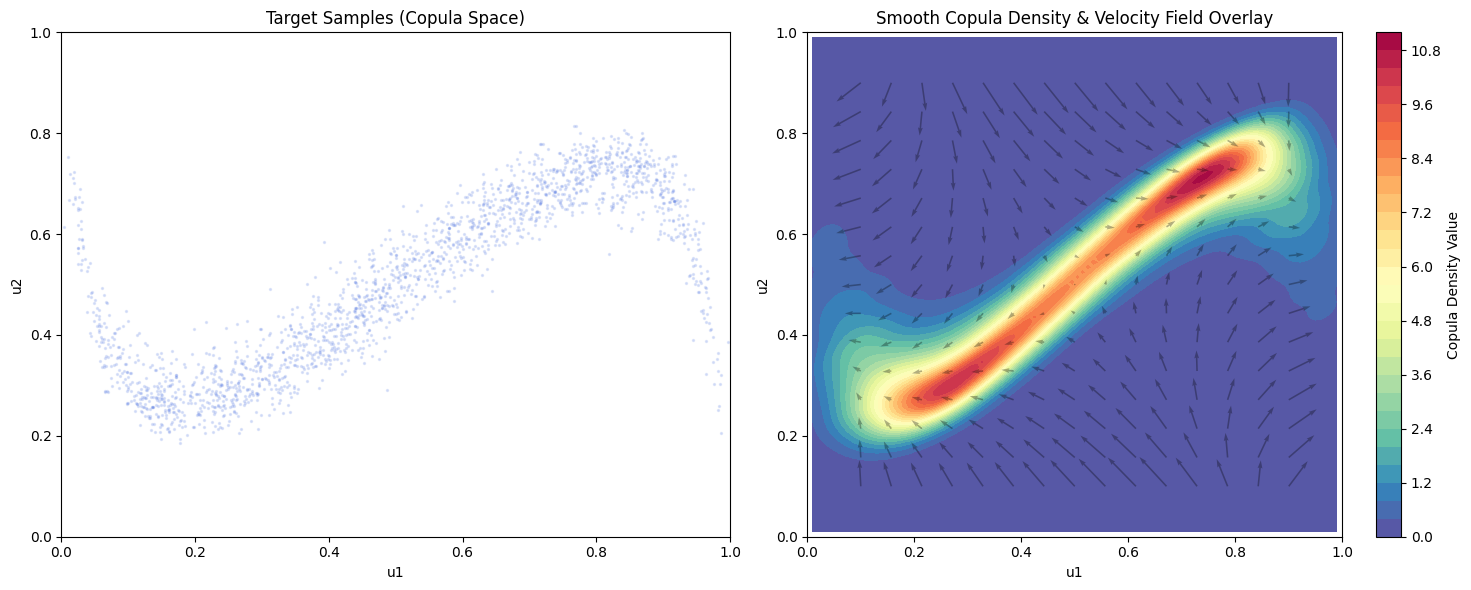

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# 1. データ生成 (ロジット空間でのS字) [cite: 643-644, 659]
device = "cuda" if torch.cuda.is_available() else "cpu"
n_samples = 10000
z1 = torch.randn(n_samples, 1) * 1.5
z2 = torch.sin(z1) + torch.randn(n_samples, 1) * 0.2
z_data = torch.cat([z1, z2], dim=1).to(device)

# 2. Flow Matching Network [cite: 309, 442-444]
class MLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim), nn.Softplus(),
            nn.Linear(hidden_dim, hidden_dim), nn.Softplus(),
            nn.Linear(hidden_dim, input_dim)
        )
    def forward(self, t, z):
        return self.net(torch.cat([t, z], dim=-1))

model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)

# 3. 学習 (Conditional Flow Matching) [cite: 311-315, 492-493]
for step in range(3000):
    optimizer.zero_grad()
    z1_batch = z_data[torch.randint(0, n_samples, (512,))]
    z0_batch = torch.randn_like(z1_batch)
    t = torch.rand(512, 1).to(device)
    zt = (1 - t) * z0_batch + t * z1_batch
    loss = torch.mean((model(t, zt) - (z1_batch - z0_batch))**2)
    loss.backward(); optimizer.step()

# 4. 高精度な密度可視化
model.eval()
with torch.no_grad():
    # 高精度サンプリング (ODEソルバー: 前進オイラー法) [cite: 332-343]
    n_gen = 20000
    zt = torch.randn(n_gen, 2).to(device)
    steps = 30
    for i in range(steps):
        t_curr = torch.full((n_gen, 1), i/steps, device=device)
        zt += (1.0/steps) * model(t_curr, zt)

    u_gen = torch.sigmoid(zt).cpu().numpy()

# 描画
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# (左) ターゲットサンプルの散布図
u_target = torch.sigmoid(z_data[:2000]).cpu().numpy()
ax[0].scatter(u_target[:, 0], u_target[:, 1], alpha=0.15, s=2, color='royalblue')
ax[0].set_title("Target Samples (Copula Space)")

# (右) KDEによる滑らかなコピュラ密度の推定 [cite: 448-449]
grid_res = 100
x, y = np.mgrid[0.01:0.99:100j, 0.01:0.99:100j]
positions = np.vstack([x.ravel(), y.ravel()])
kernel = gaussian_kde(u_gen.T)
f = np.reshape(kernel(positions).T, x.shape)

# 等高線による密度表示
cf = ax[1].contourf(x, y, f, levels=30, cmap='Spectral_r')
plt.colorbar(cf, ax=ax[1], label='Copula Density Value')

# ベクトル場の可視化 (t=0.5時点の速度場をデタッチして描画) [cite: 184, 161]
with torch.no_grad():
    u_grid = np.linspace(0.1, 0.9, 15)
    U1, U2 = np.meshgrid(u_grid, u_grid)
    u_flat = torch.tensor(np.stack([U1.ravel(), U2.ravel()], axis=1), dtype=torch.float32).to(device)
    z_flat = torch.log(u_flat / (1 - u_flat)) # Logit space
    v_flat = model(torch.full((len(z_flat), 1), 0.5, device=device), z_flat).detach().cpu().numpy()

ax[1].quiver(U1, U2, v_flat[:, 0], v_flat[:, 1], color='black', alpha=0.3, width=0.003)
ax[1].set_title("Smooth Copula Density & Velocity Field Overlay")

for a in ax:
    a.set_xlim(0, 1); a.set_ylim(0, 1)
    a.set_xlabel("u1"); a.set_ylabel("u2")

plt.tight_layout(); plt.show()